In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb
import csv
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparation

In [3]:
conn_input = duckdb.connect(database='/content/drive/MyDrive/ADSDB/colabs-part2/Train and Validation Sets Generation/prepared_data_splitted.db', read_only=True)
path = '/content/drive/MyDrive/ADSDB/colabs-part2/Model Generation/models.csv'        # Path to save models.

In [4]:
# Print tables in input database
result = conn_input.execute("SHOW TABLES;")

rows = result.fetchall()
for row in rows:
    print(row[0])

train
val


In [5]:
df_train = conn_input.execute("SELECT * FROM train").df()
df_train.head()

,Quarter,house_price_index
0,2021-10-01,135.291
1,2021-07-01,133.652
2,2021-04-01,130.937
3,2021-01-01,127.831
4,2020-10-01,127.179


In [6]:
df_val = conn_input.execute("SELECT * FROM val").df()
df_val.head()

,Quarter,house_price_index
0,2022-10-01,142.666
1,2022-07-01,143.860
2,2022-04-01,141.433
3,2022-01-01,138.742


In [7]:
# Time series require the temporal dimension to be the index
if 'Quarter' in df_train.index.names:
    print("'Quarter' is already the index.")
else:
    df_train.set_index('Quarter', inplace=True)

if 'Quarter' in df_val.index.names:
    print("'Quarter' is already the index.")
else:
    df_val.set_index('Quarter', inplace=True)

In [8]:
total_set = pd.concat([df_train, df_val], ignore_index=False)
total_set = total_set.sort_index(ascending=True)
total_set.head()

,house_price_index
Quarter,
2008-01-01,150.082
2008-04-01,149.618
2008-07-01,147.134
2008-10-01,142.511
2009-01-01,138.693


# Save and Load functions

In [9]:
def save_model(p, d, q, mae, mape, rmse, train_range, predict_range, path, mode):
  model_name = 'Arima' + '-' + str(mode) + '(' + str(p) + ',' + str(d) + ',' + str(q) + ') ' + str(train_range) + str(predict_range)

  if not os.path.exists(path):
        with open(path, mode='w', newline='') as new_csv_file:
            fieldnames = ["model_name", "p", "d", "q", "mae", "mape", "rmse", "train_range", "predict_range", "mode"]
            writer = csv.DictWriter(new_csv_file, fieldnames=fieldnames)
            writer.writeheader()

  # Check if the entry already exists in the CSV file
  entry_exists = False
  with open(path, mode='r', newline='') as csv_file:
      reader = csv.DictReader(csv_file)
      for row in reader:
          if row["model_name"] == model_name:
              entry_exists = True
              break

   # If the entry doesn't exist, add it to the CSV file
  if not entry_exists:
    with open(path, mode='a', newline='') as csv_file:
      fieldnames = ["model_name", "p", "d", "q", "mae", "mape", "rmse", "train_range", "predict_range", "mode"]
      writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
      # Check if the file is empty, and write the header if it is
      if csv_file.tell() == 0:
        writer.writeheader()
        # Write model information to the CSV file
      writer.writerow({
          "model_name": model_name,
          #"seed": seed,
          "p": p,
          "d": d,
          "q": q,
          "mae": mae,
          "mape": mape,
          "rmse": rmse,
          "train_range": train_range,
          "predict_range": predict_range,
          "mode": mode
          })
    print(f"Model and information saved to {path}")
  else:
    print(f"Model information already exists in {path}, not adding a duplicate entry.")


def load_model(path, model_name):
  try:
      with open(path, mode='r') as csv_file:
          reader = csv.DictReader(csv_file)

          for row in reader:
              if row["model_name"] == model_name:
                  return {
                      "p": int(row["p"]),
                      "d": int(row["d"]),
                      "q": int(row["q"]),
                      #"seed": np.uint32(int(row["seed"])),
                      "mae": float(row["mae"]),
                      "mape": float(row["mape"]),
                      "rmse": float(row["rmse"]),
                      "train_range": str(row["train_range"]),
                      "predict_range": str(row["predict_range"]),
                      "mode": row["mode"]
                  }

      print(f"Model with name '{model_name}' not found in {path}")
      return None
  except FileNotFoundError:
        print(f"File {path} not found.")
        return None

# ARIMA Model autofitting

In [10]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00


In [11]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False, error_action="ignore")
auto_arima

ARIMA(order=(1, 0, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
# Extract p, d, and q parameters
p, d, q = auto_arima.order

# Print the parameters
print("ARIMA(p={}, d={}, q={})".format(p, d, q))

ARIMA(p=1, d=0, q=4)


In [13]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(1, 0, 4)   Log Likelihood                -116.458
Date:                Fri, 12 Jan 2024   AIC                            244.916
Time:                        21:07:36   BIC                            257.068
Sample:                             0   HQIC                           249.627
                                 - 56                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.004    239.764      0.000       0.991       1.008
ma.L1          0.1990      0.158      1.256      0.209      -0.111       0.509
ma.L2          0.4420      0.178      2.485      0.013       0.093       0.790
ma.L3          0.2794      0.131      2.126      0.034       0.022       0.537
ma.L4          0.4406      0.130      3.391      0.001       0.186       0.695
sigma2         3.1331      0.563      5.565      0.000       2.030       4.236
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                17.62
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               2.30   Skew:                             0.99
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
# Run auto model
model = ARIMA(df_train, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provid

                               SARIMAX Results                                
Dep. Variable:      house_price_index   No. Observations:                   56
Model:                 ARIMA(1, 0, 4)   Log Likelihood                -113.923
Date:                Fri, 12 Jan 2024   AIC                            241.846
Time:                        21:07:37   BIC                            256.023
Sample:                             0   HQIC                           247.342
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        134.5859     30.989      4.343      0.000      73.849     195.323
ar.L1          0.9751      0.030     32.928      0.000       0.917       1.033
ma.L1          0.2175      0.158      1.375      0.1

In [15]:
forecast_test_auto = model_fit.forecast(len(df_val))
total_set['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)
print(total_set['forecast_auto'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='Quarter'>

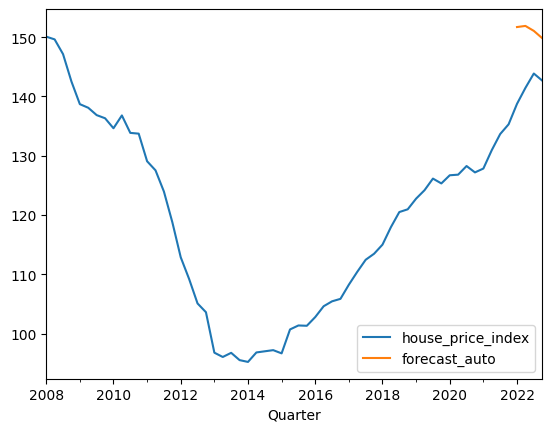

In [ ]:
total_set.plot()

In [ ]:
# Print Metrics

mae = mean_absolute_error(df_val, forecast_test_auto)
mape = mean_absolute_percentage_error(df_val, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_val, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')


mae - manual: 9.44120205964569
mape - manual: 0.06675622563794636
rmse - manual: 9.505461974892429


In [ ]:
# Save Model
train_range="2008Q1-2021Q4"
predict_range="2022Q1-2022Q4"
mode="auto"
save_model(p, d, q, mae, mape, rmse, train_range, predict_range, path, mode)

Model information already exists in /content/drive/MyDrive/ADSDB/colabs-part2/Model Generation/models.csv, not adding a duplicate entry.


# ARIMA Model Manual-Fitting

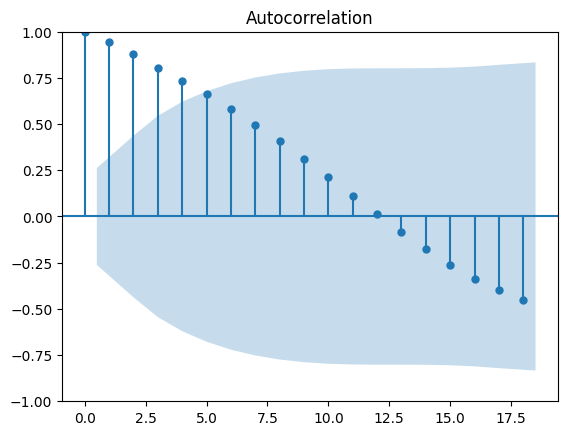

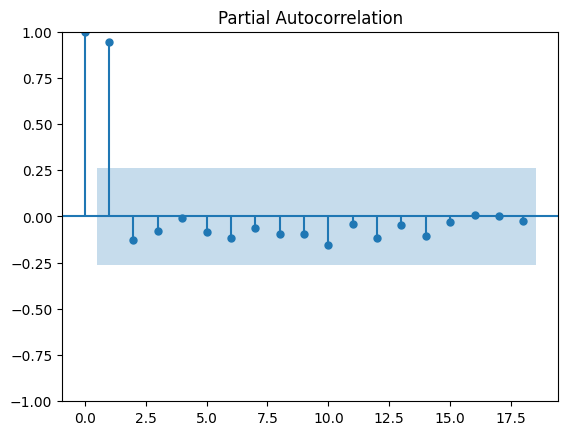

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_or = plot_acf(df_train)
pacf_or = plot_pacf(df_train)

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.46285172335385566


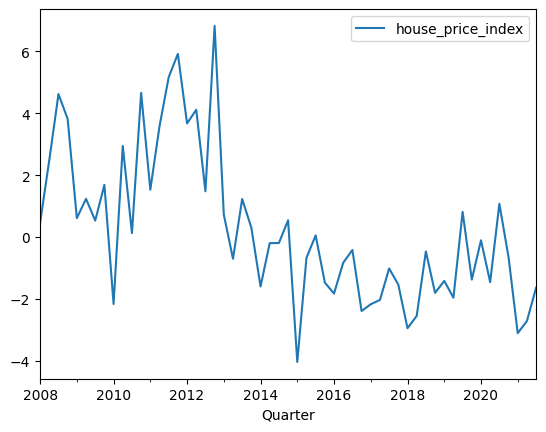

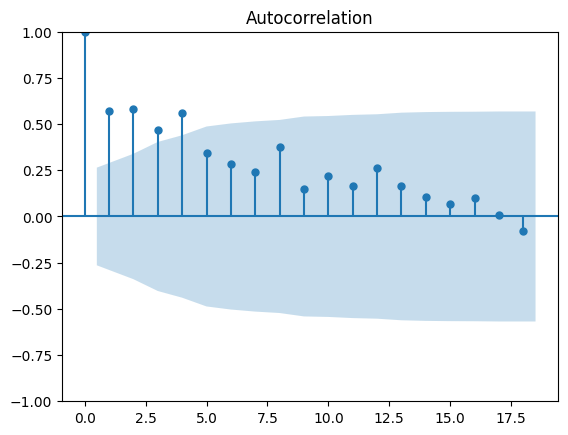

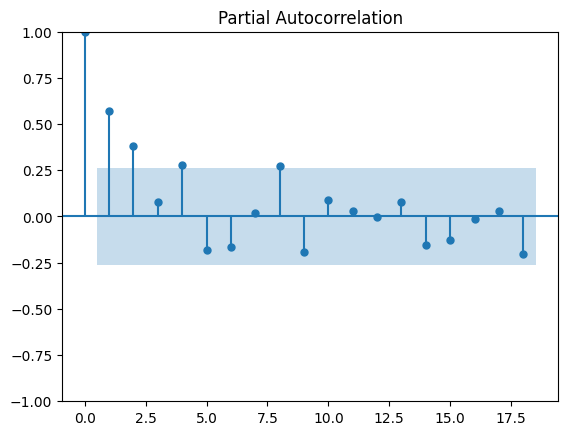

In [ ]:
# Using difference
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

In [ ]:
adf_test_diff = adfuller(df_train_diff)
print(f'p-value: {adf_test_diff[1]}')

p-value: 0.670686341020071


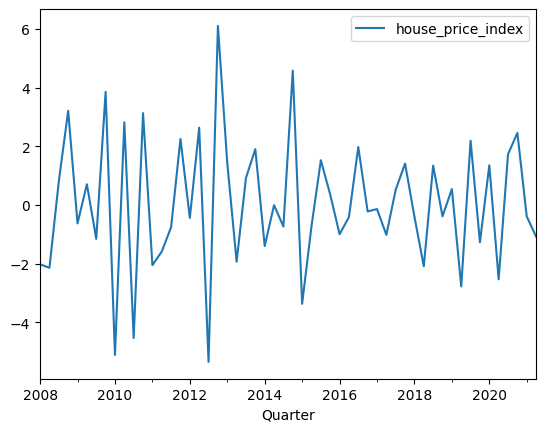

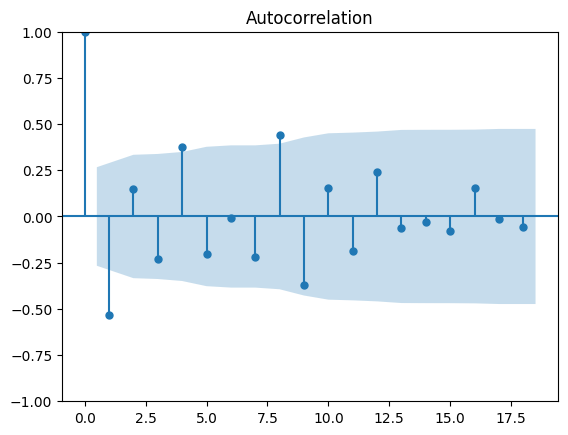

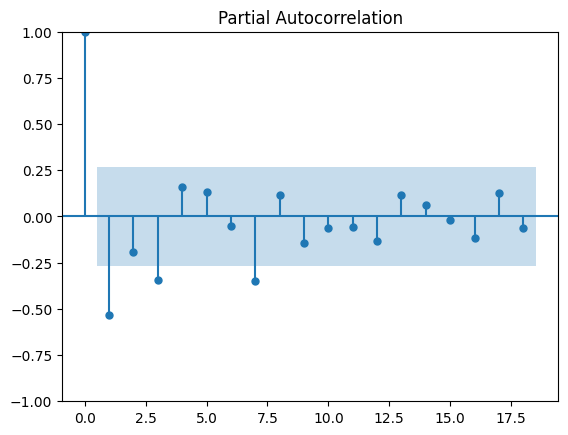

In [ ]:
# Using second difference
df_train_diff2 = df_train_diff.diff().dropna()
df_train_diff2.plot()
acf_diff2 = plot_acf(df_train_diff2)
pacf_diff2 = plot_pacf(df_train_diff2)

In [ ]:
adf_test_diff2 = adfuller(df_train_diff2)
print(f'p-value: {adf_test_diff2[1]}')

p-value: 0.011865407344589449


In [ ]:
# Choose p,d,q
p,d,q = 2,1,0

In [ ]:
# Run model
model = ARIMA(df_train, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      house_price_index   No. Observations:                   56
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -111.996
Date:                Fri, 12 Jan 2024   AIC                            229.992
Time:                        17:25:54   BIC                            236.014
Sample:                             0   HQIC                           232.320
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3399      0.138      2.464      0.014       0.070       0.610
ar.L2          0.4015      0.152      2.645      0.008       0.104       0.699
sigma2         3.3913      0.492      6.889      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provid

In [ ]:
forecast_test_manual = model_fit.forecast(len(df_val))
total_set['forecast_manual'] = [None]*len(df_train) + list(forecast_test_manual)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


            house_price_index  forecast_auto  forecast_manual
Quarter                                                      
2008-01-01            150.082            NaN              NaN
2008-04-01            149.618            NaN              NaN
2008-07-01            147.134            NaN              NaN
2008-10-01            142.511            NaN              NaN
2009-01-01            138.693            NaN              NaN
2009-04-01            138.082            NaN              NaN
2009-07-01            136.845            NaN              NaN
2009-10-01            136.313            NaN              NaN
2010-01-01            134.626            NaN              NaN
2010-04-01            136.790            NaN              NaN
2010-07-01            133.846            NaN              NaN
2010-10-01            133.718            NaN              NaN
2011-01-01            129.059            NaN              NaN
2011-04-01            127.528            NaN              NaN
2011-07-

<Axes: xlabel='Quarter'>

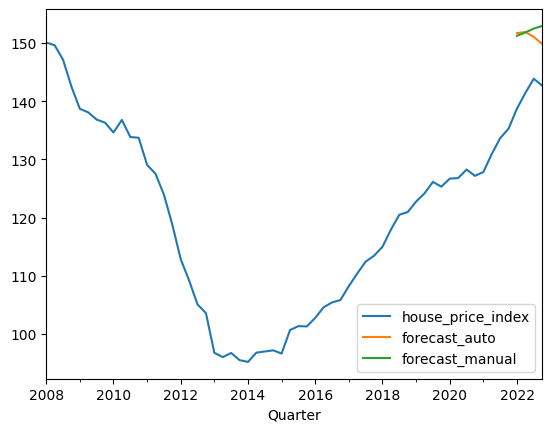

In [ ]:
print(total_set)
total_set.plot()

In [ ]:
# Print Metrics

mae = mean_absolute_error(df_val, forecast_test_manual)
mape = mean_absolute_percentage_error(df_val, forecast_test_manual)
rmse = np.sqrt(mean_squared_error(df_val, forecast_test_manual))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 10.440647473558208
mape - manual: 0.07393880460523165
rmse - manual: 10.725328138863775


In [ ]:
# Save Model
train_range="2008Q1-2021Q4"
predict_range="2022Q1-2022Q4"
mode="manual"
save_model(p, d, q, mae, mape, rmse, train_range, predict_range, path, mode)

Model and information saved to /content/drive/MyDrive/ADSDB/colabs-part2/Model Generation/models.csv
